In [1]:
from tweepy.streaming import StreamListener
from tweepy import OAuthHandler
from tweepy import Stream
import twython
from textblob import TextBlob
import json
import pandas as pd
import matplotlib.pyplot as plt
import sys
import re
import dateutil.parser
from pytz import timezone
import pytz
from collections import defaultdict
#from elasticsearch import Elasticsearch

In [2]:
#Variables that contains the user credentials to access Twitter API 
access_token = "717220472623071233-oeDgXLyYdqT92Mi06aaAGV7EtSExfKS"
access_token_secret = "tVh6WAqVqJ5Pekb3skPON4OD46dyyBAIGOiWjPkZrtglC"
consumer_key = "qiOaRLVPldazXmYmF3IaIQw4L"
consumer_secret = "FAzcCMF1UUyuNuSeddAA1nDJYPeXm6OhaCD084k1t3BZ0HleCY"

In [3]:
sgtz = timezone('Asia/Kolkata')
utc = pytz.timezone('UTC')

In [4]:
STATES = [
    'Andaman and Nicobar Islands',
    'Andhra Pradesh',
    'Arunachal Pradesh',
    'Assam',
    'Bihar',
    'Chandigarh',
    'Chhattisgarh',
    'Dadra and Nagar Haveli',
    'Daman and Diu',
    'Delhi',
    'Goa',
    'Gujarat',
    'Haryana',
    'Himachal Pradesh',
    'Jammu and Kashmir',
    'Jharkhand',
    'Karnataka',
    'Kerela',
    'Lakshadweep',
    'Madhya Pradesh',
    'Maharashtra',
    'Manipur',
    'Meghalaya',
    'Mizoram',
    'Nagaland',
    'Odisha',
    'Puducherry',
    'Punjab',
    'Rajasthan',
    'Sikkim',
    'Tamil Nadu',
    'Telangana',
    'Tripura',
    'Uttar Pradesh',
    'Uttrakhand',
    'West Bengal'
]

In [5]:
regex = re.compile('|'.join(STATES).lower())
linenum_re = re.compile(r'([A-Z][A-Z]\d+)')
retweets_re = re.compile(r'^RT\s')

enc = lambda x: x.encode('latin1', errors='ignore')

In [6]:
#This is a basic listener that just prints received tweets to stdout.

class StdOutListener(StreamListener):

    
    def on_data(self, data):
        tweet = json.loads(data)
        tweets_data.append(tweet)
        #print data
        return True

    '''
    def on_data(self, data):
        tweet = json.loads(data)

        if not tweet.has_key('user'):
            print 'No user data - ignoring tweet.'
            return True

        user = enc(tweet['user']['name'])
        text = enc(tweet['text'])

        # ignore text that doesn't contain one of the keywords
        matches = re.search(regex, text.lower())
        if not matches:
            return True

        # ignore retweets
        #if re.search(retweets_re, text):
        #    return True

        location = enc(tweet['user']['location'])
        source = enc(tweet['source'])
        d = dateutil.parser.parse(enc(tweet['created_at']))

        # localize time
        d_tz = utc.normalize(d)
        localtime = d.astimezone(sgtz)
        tmstr = localtime.strftime("%Y%m%d-%H:%M:%S")

        # append the hourly tweet file
        #with open('tweets-%s.data' % tmstr.split(':')[0], 'a+') as f:
        #    f.write(data)

        # is this a geocoded tweet?
    
        geo = tweet['geo']
        if geo and geo['type'] == 'Point':
            # collect location of mrt station
            coords = geo['coordinates']
            ln = re.search(linenum_re, text)
            if ln:
                with open('mrt_station_locations.csv', 'a+') as mrtgeo:
                    print("Found geo coords for MRT Station (%s) '%s': (%f, %f)\n" %
                            (ln.group(), matches.group(), coords[1], coords[0]))
                    mrtgeo.write("%f\t%f\t%s\t%s\n" %
                            (coords[1], coords[0], matches.group(), ln.group()))

        '''
        # print summary of tweet
        #print('%s\n%s\n%s\n%s\n%s\n\n ----------------\n' % (user, location, source, tmstr, text))
    
    def on_error(self, status):
        print status



In [16]:
# create instance of elasticsearch
#es = Elasticsearch()


class TweetStreamListener(StreamListener):

    # on success
    def on_data(self, data):

        # decode json
        dict_data = json.loads(data)

        # pass tweet into TextBlob
        tweet = TextBlob(dict_data["text"])

        # output sentiment polarity
        print tweet.sentiment.polarity

        # determine if sentiment is positive, negative, or neutral
        if tweet.sentiment.polarity < 0:
            sentiment = "negative"
        elif tweet.sentiment.polarity == 0:
            sentiment = "neutral"
        else:
            sentiment = "positive"

        # output sentiment
        print sentiment

        '''
        # add text and sentiment info to elasticsearch
        es.index(index="sentiment",
                 doc_type="test-type",
                 body={"author": dict_data["user"]["screen_name"],
                       "date": dict_data["created_at"],
                       "message": dict_data["text"],
                       "polarity": tweet.sentiment.polarity,
                       "subjectivity": tweet.sentiment.subjectivity,
                       "sentiment": sentiment})
        '''
        return True

    # on failure
    def on_error(self, status):
        print status


In [7]:
if __name__ == '__main__':

    #This handles Twitter authentification and the connection to Twitter Streaming API
    global tweets_data
    tweets_data = []
    l = StdOutListener()
    #l = TweetStreamListener()
    auth = OAuthHandler(consumer_key, consumer_secret)
    auth.set_access_token(access_token, access_token_secret)
    stream = Stream(auth, l)

    #This line filter Twitter Streams to capture data by the keywords: 'education'
    stream.filter(track=['#edpolicy,#edreform,#edpolitics'])

KeyboardInterrupt: 

In [8]:
tweets_dict = defaultdict(list)
for tweets in tweets_data:
    if tweets.has_key('user'):
        #print 'No user data - ignoring tweet.'
        user = enc(tweets['user']['name'])
        text = enc(tweets['text'])

        # ignore text that doesn't contain one of the keywords
        matches = re.search(regex, text.lower())
        #print matches.group()
        if matches:
            #print matches.group()
            if  matches.group() in tweets_dict.keys():
                #print "First case"
                tweets_dict[matches.group()].append(tweets)
            else:
                #print "second case"
                tweets_dict[matches.group()]=list()
                tweets_dict[matches.group()].append(tweets)

        # ignore retweets
        #if re.search(retweets_re, text):
        #    return True

In [12]:
print tweets_dict.keys()
for tweets in tweets_data:
    text = enc(tweets["text"])
    print text

[]
RT @tedfujimoto: Top private high schools campaign to kill traditional transcripts &amp; change college admissions https://t.co/pT2s6jk89F #hig
RT @tedfujimoto: Top private high schools campaign to kill traditional transcripts &amp; change college admissions https://t.co/pT2s6jk89F #hig
RT @Lynch39083: At What Age Can We Introduce Children to Honest History? https://t.co/fYFISlj8M0 #edpolicy https://t.co/Je4CzHBUTH
RT @tedfujimoto: Of course! Study: Better school climate translates to stronger student performance - Trusted https://t.co/FEDjdsrdcO #edpo
RT @tedfujimoto: Of course! Study: Better school climate translates to stronger student performance - Trusted https://t.co/FEDjdsrdcO #edpo
Vol 12, 4 2017 iJET International Journal of Emerging Technologies in Learning #elearning #higherED  https://t.co/KPqsyHi9e9 #TIC #edreform
Parental Involvement: Strengthening Communication is the Key https://t.co/Ie1qkE4qLE #edpolicy
Parental Involvement: Strengthening Communication is the Key ht

In [11]:
positive = defaultdict(list)
negative = defaultdict(list)
neutral = defaultdict(list)
for keys in tweets_dict.keys():
    for tweets in tweets_dict[keys]:
        # pass tweet into TextBlob
        tweet = TextBlob(tweets["text"])

        # output sentiment polarity
        #print keys
        #print tweet.sentiment.polarity

        # determine if sentiment is positive, negative, or neutral
        if tweet.sentiment.polarity < 0:
            #sentiment = "negative"
            if keys in negative.keys():
                negative[keys].append(tweets)
            else:
                negative[keys]=[]
                negative[keys].append(tweets)
        elif tweet.sentiment.polarity == 0:
            #sentiment = "neutral"
            if keys in neutral.keys():
                neutral[keys].append(tweets)
            else:
                neutral[keys]=[]
                neutral[keys].append(tweets)
        else:
            #sentiment = "positive"
            if keys in positive.keys():
                positive[keys].append(tweets)
            else:
                positive[keys]=[]
                positive[keys].append(tweets)
        # output sentiment
        #print sentiment

In [12]:
print len(positive.keys())
print len(neutral.keys())
print len(negative.keys())

13
18
4


In [13]:
print len(tweets_data)
tweets = pd.DataFrame()

tweets['text'] = map(lambda tweet: tweet['text'], tweets_data)
tweets['lang'] = map(lambda tweet: tweet['lang'], tweets_data)
tweets['country'] = map(lambda tweet: tweet['place']['country'] if tweet['place'] != None else None, tweets_data)


2770


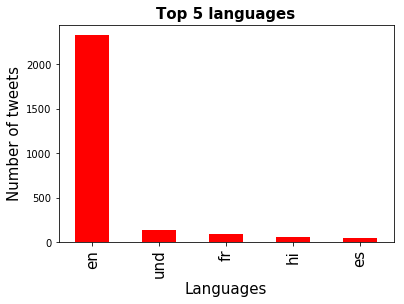

In [14]:
tweets_by_lang = tweets['lang'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')
plt.show()

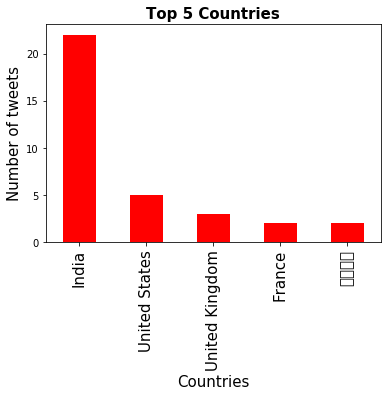

In [19]:
tweets_by_lang = tweets['country'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Countries', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 Countries', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='red')
plt.show()